In [1]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import NN_evaluation
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Import the original data for plotting
sc = "sc01"
period = "2030"
folder = "../Data/3-bus_DC_fy/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
len(all_executions)
executions = all_executions[0:40]
te_s = 0.3
val_s = 0.3
outp = "SystemCosts"
hyperloop_name = "rand_Hours_3-bus_DC_0.3_v0.3_PF_0_20"

In [4]:
#Analyze the loss results
df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col = 0)
df_losses.columns

Index(['Model_type', 'Dor', 'Relu_out', 'Batch_size', 'Lr', 'Epochs',
       'Min_val', 'Nb_hours_used', 'Tr_l', 'Te_l', 'V_l', 'Tr_l_mse',
       'Te_l_mse', 'V_l_mse', 'Tr_l_mae', 'Te_l_mae', 'Te_l_mae_man',
       'V_l_mae', 'fy_l', 'fy_l_mse', 'fy_l_mae', 'fy_l_mae_man', 'Train_time',
       'Eval_time', 'alpha', 'beta', 'MAE', 'Test size', 'Val size'],
      dtype='object')

In [5]:
df_losses.sort_values(by="fy_l_mse")

,Model_type,Dor,Relu_out,Batch_size,Lr,Epochs,Min_val,Nb_hours_used,Tr_l,Te_l,...,fy_l_mse,fy_l_mae,fy_l_mae_man,Train_time,Eval_time,alpha,beta,MAE,Test size,Val size
574,"(3, 1)",0,False,64,0.002500,256,min_val,2900,0.002252,0.002178,...,0.000015,0.002213,0.002213,232.370164,0.009734,0,1,True,0.3,0.3
426,"(3, 1)",0,False,64,0.002500,128,min_val,2100,0.002819,0.002820,...,0.000023,0.002775,0.002775,82.381990,0.012685,0,1,True,0.3,0.3
512,"(0, 0)",0,False,64,0.000625,256,min_val,2900,0.000036,0.000038,...,0.000038,0.003688,0.003688,149.397344,0.008541,0,1,False,0.3,0.3
513,"(0, 0)",0,False,64,0.000625,256,all_epochs,2900,0.000039,0.000040,...,0.000040,0.003842,0.003842,149.397344,0.005532,0,1,False,0.3,0.3
514,"(0, 0)",0,False,64,0.000625,256,min_val,2900,0.001987,0.001962,...,0.000042,0.001936,0.001936,152.284733,0.008132,0,1,True,0.3,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,"(3, 1)",0,False,64,0.000625,64,min_val,10,0.557810,0.669510,...,0.364694,0.597219,0.597219,0.368085,0.002657,0,1,True,0.3,0.3
710,"(3, 1)",0,False,64,0.002500,64,min_val,20,0.673260,0.750180,...,0.493149,0.696467,0.696467,0.534554,0.002423,0,1,True,0.3,0.3
711,"(3, 1)",0,False,64,0.002500,64,all_epochs,20,0.673260,0.750180,...,0.493149,0.696467,0.696467,0.534554,0.003408,0,1,True,0.3,0.3
984,"(3, 1)",0,False,64,0.000625,64,min_val,60,0.667303,0.715359,...,0.690751,0.826237,0.826237,1.392664,0.003669,0,1,False,0.3,0.3


<Axes: xlabel='Nb_hours_used', ylabel='fy_l_mae'>

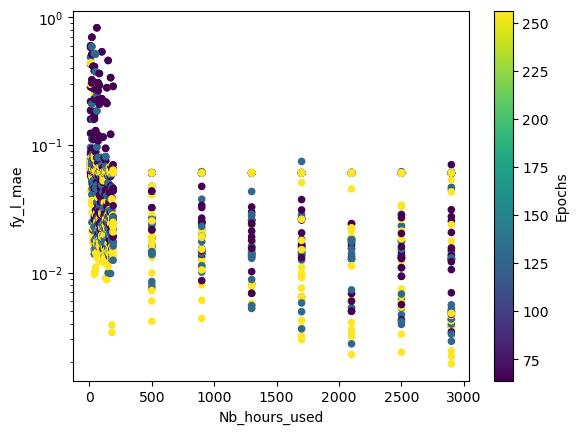

In [6]:
df_losses[df_losses.Nb_hours_used <=10000].plot.scatter(x="Nb_hours_used",y="fy_l_mae",c = "Epochs",colormap = "viridis",logy = True)

<Axes: xlabel='Te_l_mse', ylabel='fy_l_mse'>

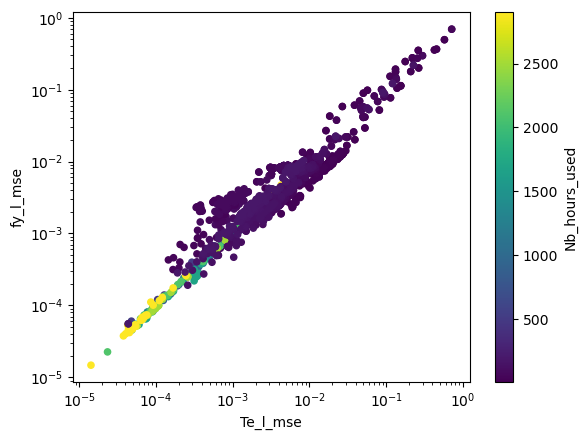

In [8]:
df_losses.plot.scatter(x="Te_l_mse",y="fy_l_mse",c = "Nb_hours_used",colormap = "viridis",logy=True,logx=True)

In [12]:
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"])
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter,all_executions)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

#Extract fy sets
t_in_fy, t_out_fy, t_inter_fy, maxs = DataLoading.concat_all_exec_fy(dfs_in, dfs_out, dfs_inter_j,all_executions)

input_f_sc01_Network_Existing_Generation_Full_2030.csv
14
input_f_sc01_Network_Full_Generation_Full_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_1_Node_3_cac3_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac1_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac2_2030.csv
14
input_f_sc01_PINT_Network_Line_In_Node_2_Node_3_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac2_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_2_cac3_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_Node_3_cac1_2030.csv
14
input_f_sc01_TOOT_Network_Line_In_Node_1_No

In [13]:
df_losses = pd.read_csv(f"Loss_results_csv/{hyperloop_name}.csv",index_col=0)

f = df_losses.Nb_hours_used >=1

loss_to_sort = "fy_l_mse"

[28, 42, 8, 3, 1]
OE_2900hours_(3, 1)h_256e_0.0025lr_0dor_Falsero_64bs_0ill_TrueMAE min_val
trained_models/test_loss_rand_hours_3-bus_DC_0.3_v0.3_PF_0_20/min_val/model_OE_2900hours_(3, 1)h_256e_0.0025lr_0dor_Falsero_64bs_0ill_TrueMAE.pth


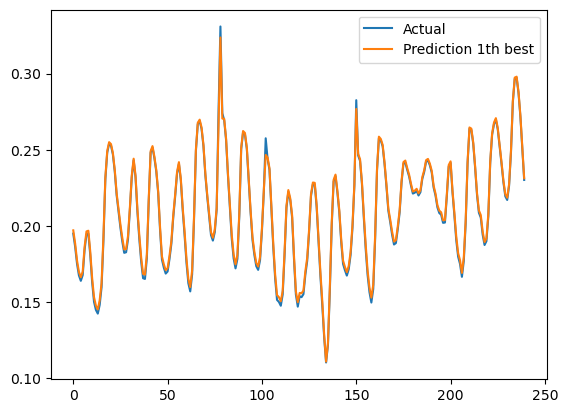

In [32]:
#Visualisation of multiple models in input order
ex = all_executions[4]


#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_out = dfs_out[ex].sum(axis=1).to_numpy()


s = 24*10
e=s+24*10
plt.plot(ex_out[s:e]/maxs["out"],label = "Actual")

for xth_best in [1]: 
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()

Network_Existing_Generation_Full
[28, 42, 8, 3, 1]
OE_2900hours_(3, 1)h_256e_0.0025lr_0dor_Falsero_64bs_0ill_TrueMAE min_val
trained_models/test_loss_rand_hours_3-bus_DC_0.3_v0.3_PF_0_20/min_val/model_OE_2900hours_(3, 1)h_256e_0.0025lr_0dor_Falsero_64bs_0ill_TrueMAE.pth
Network_Full_Generation_Full
[28, 42, 8, 3, 1]
OE_2900hours_(3, 1)h_256e_0.0025lr_0dor_Falsero_64bs_0ill_TrueMAE min_val
trained_models/test_loss_rand_hours_3-bus_DC_0.3_v0.3_PF_0_20/min_val/model_OE_2900hours_(3, 1)h_256e_0.0025lr_0dor_Falsero_64bs_0ill_TrueMAE.pth


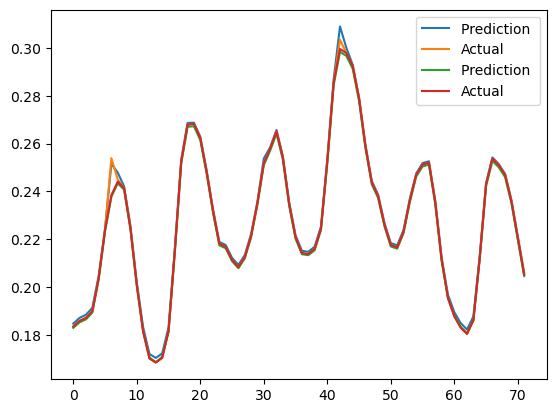

In [33]:
#Visualisation of multiple executions in input order


s = 0
e=s+72


for ex_i in [0,1]:
    ex = all_executions[ex_i]
    print(ex)
    row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)
    ex_in = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
    ex_out = dfs_out[ex].sum(axis=1).to_numpy()/maxs["out"]
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction ")
    plt.plot(ex_out[s:e],label = f"Actual")

plt.legend()

Text(0.5, 1.0, 'Derived line benefits')

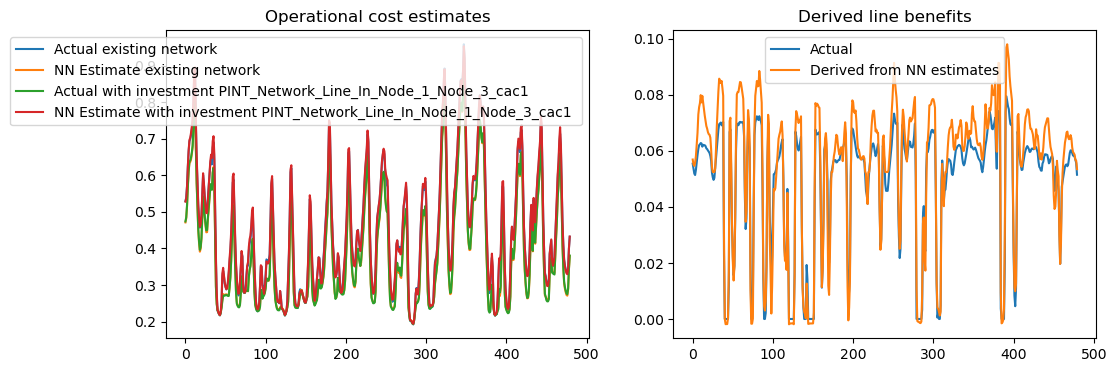

In [35]:
#Visualisation of multiple executions in input order
# f = df_losses.alpha ==0.0
# loss_to_sort = "Te_l_mae"
# xth_best = 1
# row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
# m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)

#ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])

l_idx = 5
ex = all_executions[l_idx]
negf = all_executions[0]


ex_in_e = torch.nan_to_num(dfs_in[ex].to_numpy()/maxs["in"])
ex_in_negf = torch.nan_to_num(dfs_in[negf].to_numpy()/maxs["in"])

prediction_e = m(ex_in_e.float())[0].detach().numpy()
prediction_negf = m(ex_in_negf.float())[0].detach().numpy()

actual_e = NN_evaluation.get_actual_from_dfs_out(ex,dfs_out)/maxs["out"]
actual_negf = NN_evaluation.get_actual_from_dfs_out(negf,dfs_out)/maxs["out"]

lb_est = prediction_negf- prediction_e
lb_actual = NN_evaluation.calculate_lb_from_dfs_out(dfs_out,ex)/maxs["out"]



#s= random.randint(0,len(actual_e))
s=5000
e = s+24*20

fig, axs = plt.subplots(1,2,figsize = (12,4))

axs[0].plot(actual_negf[s:e],label = "Actual existing network")
axs[0].plot(prediction_e[s:e],label = "NN Estimate existing network")
axs[0].plot(actual_e[s:e],label = f"Actual with investment {ex}")
axs[0].plot(prediction_negf[s:e],label = f"NN Estimate with investment {ex} ")

axs[0].legend()
axs[0].set_title("Operational cost estimates")


axs[1].plot(lb_actual[s:e],label = "Actual")
axs[1].plot(lb_est[s:e],label = "Derived from NN estimates")

axs[1].legend()
axs[1].set_title(f"Derived line benefits")

#axs[2].hist(lb_actual/actual_negf,bins= 100)


In [27]:
#Check loss calculation 
f = df_losses.Nb_hours_used >= 1
loss_to_sort = "fy_l_mse"
xth_best = 1
row = NN_evaluation.find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = NN_evaluation.create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name,cluster_run=False)
prediction = m(t_in_fy.float())

[3]
3
1
OE_500hours_(0, 0)h_128e_0.0025lr_0dor_Falsero_64bs_0ill_FalseMAE min_val
trained_models/test_loss_rand_hours_3-bus_DC_0.3_v0.3_PF_0_20/min_val/model_OE_500hours_(0, 0)h_128e_0.0025lr_0dor_Falsero_64bs_0ill_FalseMAE.pth


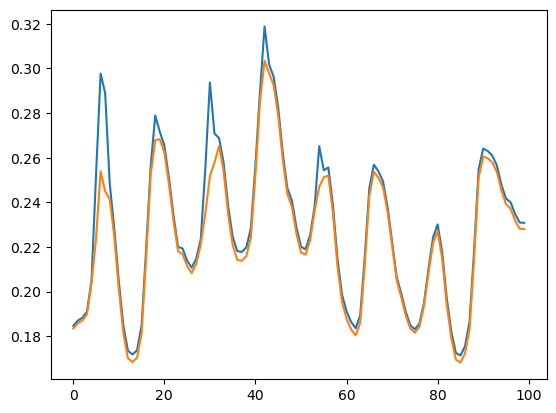

In [28]:
s = 0
e = 100
plt.plot(prediction[0].squeeze()[s:e].detach())
plt.plot(t_out_fy[s:e],label = f"Actual")

In [29]:
#Calculate loss manually 
manual_diff = prediction[0].detach().numpy().transpose() - t_out_fy.numpy()
np.mean(np.abs(manual_diff)),np.mean(np.square(manual_diff))

(0.005923492078858405, 0.00010409523165243718)

In [30]:
row.fy_l_mae.item(),row.fy_l_mse.item()

(0.0059234920788584, 0.0001040952316524)